In [1]:
import sqlite3
import pandas as pd
import seaborn as sns


Reading in the data into Python using pandas. Had to use sqlite command to read in fire data, then convert to dataframe using pandas.

In [2]:
cnx = sqlite3.connect('Desktop/FPA_FOD_20170508.sqlite')

emissions = pd.read_excel('Desktop/emmissions.xlsx',header=4)

fire_df = pd.read_sql_query(
    "SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS FROM 'Fires'", cnx)

Cleaning up the CO2 emissions dataset using a dictionary to convert state names into abbreviations. In order to concatanate the emissions dataset with the fire data set, we need all of the state names to be abbreviated. Dictionary was obtained from https://gist.github.com/rogerallen/1583593. Then, we melted the emissions dataframe in order to make the "Year" columns into individual rows to facilitate concatination with the fire dataframe. Also renamed the "State" column to "STATE" to make the column names equal. 


In [3]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
    'Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD',
    'Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT',
    'Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT',
    'Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
}

emissions = emissions.dropna()

emissions = emissions.replace({"State": us_state_abbrev})


emissions = pd.melt(emissions, id_vars=["State"], 
                  var_name="Year", value_name="CO2")

emissions = emissions.rename(index=str, columns={"State": "STATE"})

More cleaning of the emissions dataframe, removed the absoulte and percent emissions by state. We are striclty looking at emissions by state, by year, rather than the United States as whole and the total of the years in the data.

In [4]:
emissions = emissions[emissions.STATE != 'Total of states (unadjusted)¹']

emissions = emissions[emissions.STATE != 'United States']

emissions= emissions[emissions.Year != 'Percent']

emissions = emissions[emissions.Year != 'Absolute']

Cleaning the fire data, we had to rename the FIRE_YEAR column to be "Year" in order to match up with the emissions dataframe column titled "Year"

In [5]:
fire_df = fire_df.rename(index=str, columns={"FIRE_YEAR": "Year"})

Next, with all the cleaning necessary for merging the emissions and fire datasets, we merged them to create a final data frame called "final_df"

In [6]:
final_df= fire_df.merge(emissions,how='outer')

Next, we felt it necessary to remove all the null values in the final data frame. This got rid of all the years in which there was either only fire data or only emissions data, and not both. This made the range of years end up being 2000 to 2015, which are the years in which we have both wildfire data and emissions data.

In [7]:
final_df.dropna(axis=0,inplace=True)

The following graphs are for the purpose of Exploratory Data Analysis (EDA). The first graph is the density of wildfires based on latitude. The second graph is the denisty of wildfires based on longitude. The third graph is the density based on both longitude and latitude, which outlines the density of wildfires in the United States. The fourth graph shows the number of wildfires and the size of the wildfires by cause. This only shows the first 100,000 data points, considering it is difficult to effectively visualize over a million data points with a cat plot.

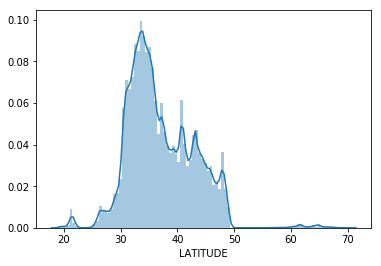

In [22]:
sns.distplot(final_df['LATITUDE'],bins=100)

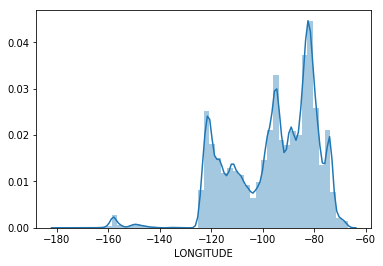

In [9]:
sns.distplot(final_df['LONGITUDE'])

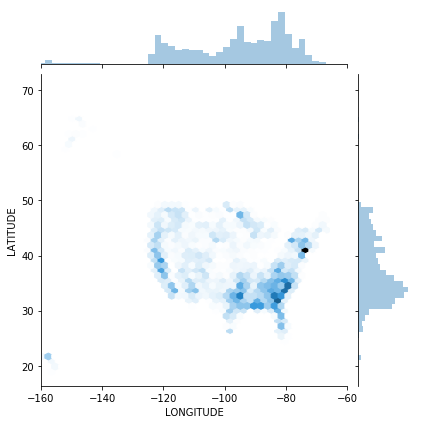

In [10]:
sns.jointplot('LONGITUDE','LATITUDE',data=final_df,kind='hex',xlim=(-160,-60))

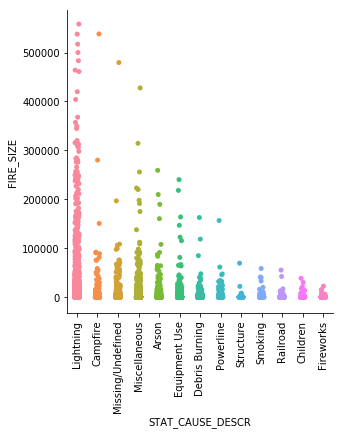

In [11]:
by_cause = final_df.sort_values(by = "FIRE_SIZE", ascending=False)[:100000]
g = sns.catplot(x="STAT_CAUSE_DESCR",y="FIRE_SIZE", hue="STAT_CAUSE_DESCR", data=by_cause)
g.set_xticklabels(rotation=90)

Next, we created dummy variables for the categorical data (fire cause and state name) in order to see if there was a correlation between fire size and both state and fire cause. This will help us with ou

In [12]:
df_cause_dummies= pd.concat([final_df, pd.get_dummies(final_df['STAT_CAUSE_DESCR'])], axis=1)

In [13]:
df_state_dummies = pd.concat([final_df, pd.get_dummies(final_df['STATE'])], axis=1)

In [14]:
df_class_dummies = pd.concat([df_state_dummies, pd.get_dummies(final_df['FIRE_SIZE_CLASS'])], axis=1)

Next we have to create lists of what we want to check the correlations between the columns in our data. We want to take a look at all the columns that have the causes, fire size classes and states in order to find correlation between each other.

In [15]:
corr_causes = df_cause_dummies[['Miscellaneous', 'Debris Burning', 'Children', 'Arson',
       'Lightning', 'Equipment Use', 'Campfire', 'Smoking', 'Railroad',
       'Fireworks', 'Structure', 'Powerline', 'Missing/Undefined','FIRE_SIZE', 'CO2']]

In [16]:
corr_state = df_state_dummies[["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY","FIRE_SIZE", "CO2"]]

In [17]:
corr_size_class = df_class_dummies[["A","B","C","D","E","F","G", "CO2", "FIRE_SIZE"]]

The following are the correlation heatmaps for fire size and CO2 with state, fire size class and 

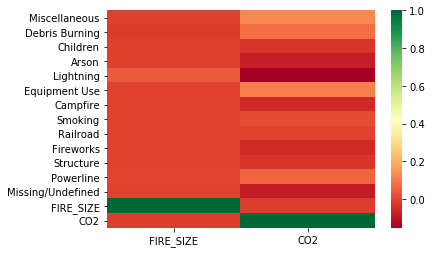

In [18]:
sns.heatmap(corr_causes.corr()[['FIRE_SIZE','CO2']], cmap='RdYlGn')


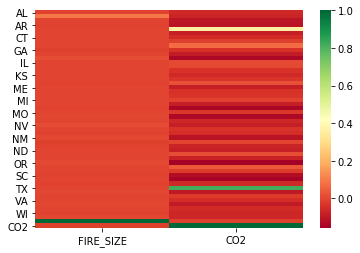

In [19]:
sns.heatmap(corr_state.corr()[['FIRE_SIZE','CO2']], cmap='RdYlGn')


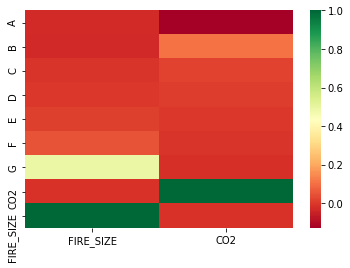

In [20]:
sns.heatmap(corr_size_class.corr()[['FIRE_SIZE','CO2']], cmap='RdYlGn')

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
final_df.head()

,Year,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,CO2
0,2005.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.1,A,383.75
1,2005.0,Debris Burning,40.968056,-122.433889,CA,2453437.5,0.8,B,383.75
2,2005.0,Debris Burning,41.233611,-122.283333,CA,2453444.5,1.0,B,383.75
3,2005.0,Debris Burning,41.037222,-123.533056,CA,2453548.5,0.1,A,383.75
4,2005.0,Miscellaneous,34.174444,-117.765000,CA,2453484.5,0.1,A,383.75


In [32]:
y = final_df['FIRE_SIZE'].values.reshape(-1,1)

In [36]:
form_lr = smf.ols(formula = 'y ~ C(STAT_CAUSE_DESCR) + LATITUDE + LONGITUDE + C(STATE) + DISCOVERY_DATE + C(FIRE_SIZE_CLASS) + CO2 ', 
              data=final_df)
mlr = form_lr.fit()

In [37]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     5965.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:27:03   Log-Likelihood:            -1.1859e+07
No. Observations:             1286232   AIC:                         2.372e+07
Df Residuals:                 1286160   BIC:                         2.372e+07
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  489.1375   3557.673      0.137      0.891   -6483.780    7462.055
C(STAT_CAUSE_DESCR)[T.Campfire]              1.5433     12.799      0.121      0.904     -23.542      26.628
C(STAT_CAUSE_DESCR)[T.Children]             -1.8696     14.251     -0.131      0.896     -29.802      26.062
C(STAT_CAUSE_DESCR)[T.Debris Burning]       -9.6177      7.538     -1.276      0.202     -24.392       5.157
C(STAT_CAUSE_DESCR)[T.Equipment Use]        -5.9796      9.948     -0.601      0.548     -25.477      13.518
C(STAT_CAUSE_DESCR)[T.Fireworks]            10.7308     26.687      0.402      0.688     -41.575      63.036
C(STAT_CAUSE_DESCR)[T.Lightning]            47.4279      9.245      5.130      0.000      29.308      65.548
C(STAT_CAUSE_DESCR)[T.Miscellaneous]        -2.4404      7.955     -0.307      0.759     -18.032      13.151
C(STAT_CAUSE_DESCR)[T.Missing/Undefined]   -17.2400     10.845     -1.590      0.112     -38.495       4.015
C(STAT_CAUSE_DESCR)[T.Powerline]           -58.3711     22.647     -2.577      0.010    -102.759     -13.984
C(STAT_CAUSE_DESCR)[T.Railroad]              4.0193     20.451      0.197      0.844     -36.064      44.102
C(STAT_CAUSE_DESCR)[T.Smoking]              -3.1714     14.973     -0.212      0.832     -32.517      26.174
C(STAT_CAUSE_DESCR)[T.Structure]           -73.1686     44.521     -1.643      0.100    -160.428      14.091
C(STATE)[T.AL]                           -1512.5964     87.919    -17.204      0.000   -1684.915   -1340.278
C(STATE)[T.AR]                           -1483.7010     80.460    -18.440      0.000   -1641.399   -1326.003
C(STATE)[T.AZ]                           -1394.2639     65.042    -21.437      0.000   -1521.743   -1266.785
C(STATE)[T.CA]                           -1398.6056     81.159    -17.233      0.000   -1557.674   -1239.537
C(STATE)[T.CO]                           -1481.9685     66.131    -22.410      0.000   -1611.582   -1352.355
C(STATE)[T.CT]                           -1648.6518    106.595    -15.467      0.000   -1857.574   -1439.730
C(STATE)[T.DE]                           -1615.7858    219.936     -7.347      0.000   -2046.852   -1184.719
C(STATE)[T.FL]                           -1555.6881     98.761    -15.752      0.000   -1749.256   -1362.120
C(STATE)[T.GA]                           -1531.8740     91.957    -16.659      0.000   -1712.108   -1351.640
C(STATE)[T.HI]                            -966.1208     80.498    -12.002      0.000   -1123.894    -808.348
C(STATE)[T.IA]                           -1531.6914     85.149    -17.988      0.000   -1698.580   -1364.803
C(STATE)[T.ID]                           -1425.4546     55.613    -25.632      0.000   -1534.454   -1316.456
C(STATE)[T.IL]                 